### 

### Exploration of pairwise string similarity algorithms 

Numerous string similarity measuring algirithms are studied below to understand how they work and which one would be the most stuitable. The end goal is to generate a pairwise dissimilarity matrix from (one of) the best algorithms. With such a matrix, we can use technqiues like Multi Dimensional Scaling to plot API strings as points. Clustering algorithms could then be used used to further understand the cohesity of API names. This will be the focus of the other associated jupyter notebook, $clustering.ipynb$

In [1]:
import numpy as np
from Bio import pairwise2
from Bio.Seq import Seq 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
similar_strings  = ["user_id", "userid", "UserId", "userID"]


#### Levenshtein
The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

It is a metric string distance. The implementation we use is dynamic programming (Wagner–Fischer algorithm).

The space requirement is $\mathcal{O}(M)$. The algorithm runs in $\mathcal{O}(M \times N)$. $M$ could be understood to be the length of the longer string. 

In [3]:
from strsimpy.levenshtein import Levenshtein
levenshtein = Levenshtein()
print('The levenshtein.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], levenshtein.distance(similar_strings[0], similar_strings[1])))

The levenshtein.distance between user_id and userid is 1


Since we can find out pairwise distances betwen two strings, we can use such distances as our dissimilarty to generate dissimilarity matrices. such matrices can then help use "plot" words. Such a dissimilarity matrix would be symmteric and the diagonal elements are $0$. Code below to plot will be recycled for each algorithm. 

In [4]:
def calculate_dissimilarity_matrix(api_strings, pairwise_dissimilarity_measure):
    size = len(api_strings)
    inconsistency_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            if i < j:
                string1  = api_strings[i]
                string2 = api_strings[j]
                if len(string1) == 0:
                    return len(string2)
                if(len(string2) == 0):
                    return len(string1)

                dissimilarity = pairwise_dissimilarity_measure(string1, string2)
                inconsistency_matrix[i][j] = dissimilarity
    inconsistency_matrix = inconsistency_matrix + inconsistency_matrix.T - np.diag(np.diag(inconsistency_matrix))
    return inconsistency_matrix

In [5]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, levenshtein.distance)
print(inconsistency_matrix)

[[0. 1. 3. 3.]
 [1. 0. 2. 2.]
 [3. 2. 0. 2.]
 [3. 2. 2. 0.]]


We can now use this dissimilarity matrix to convert the words into a set of points on the $2D$ plane. We use MDS for this. MDs (Multidimensional scaling)
maps points residing in a higher-dimensional space to a lower-dimensional space while preserving the distances between those points as much as possible. Because of this, the pairwise distances between points in the lower-dimensional space are matched closely to their actual distances. Thus, our string points in some arbitrary $N$-dimensions (which is equal to their respective lengths), will be converted into $2-D$ points by preserving their respective distances. Note, we can also plot them in $3-D.$



In [6]:
from sklearn.manifold import MDS
def plot_words(inconsistency_matrix, title, annotate=False):
    embedding = MDS(n_components=2, dissimilarity  = "precomputed")
    fitted_strings = embedding.fit_transform(inconsistency_matrix)
    fitted_strings
    x = fitted_strings[:,0]
    y = fitted_strings[:,1]
    plt.scatter(x, y)
    if annotate:
        for i, txt in enumerate(similar_strings):
            plt.annotate(txt, (x[i], y[i]))
    plt.title(title)

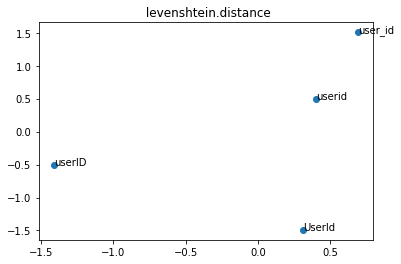

In [7]:
matplotlib.rcParams["figure.dpi"] = 150
plot_words(inconsistency_matrix, title = " levenshtein.distance", annotate=True)

#### Normalized Levenshtein
This distance is computed as levenshtein distance divided by the length of the longer string. The resulting value is always in the interval $[0.0, 1.0]$ but it is not a metric anymore. By metric, we mean it preserves triangle inequality. 



In [8]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

normalized_levenshtein = NormalizedLevenshtein()
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, normalized_levenshtein.distance)
print(inconsistency_matrix)


[[0.         0.14285714 0.42857143 0.42857143]
 [0.14285714 0.         0.33333333 0.33333333]
 [0.42857143 0.33333333 0.         0.33333333]
 [0.42857143 0.33333333 0.33333333 0.        ]]


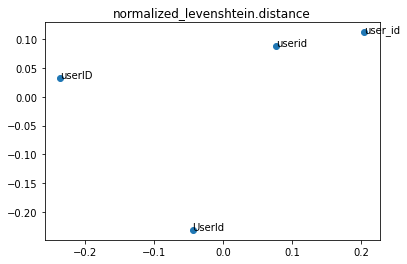

In [9]:
plot_words(inconsistency_matrix, title = "normalized_levenshtein.distance", annotate=True)

#### Jaro-Winkler
Jaro-Winkler is a string edit distance that was developed in the area of duplicate detection. The Jaro-Winkler distance metric is designed and best suited for short strings such as person names, and to detect typos. As the vocabulary artifact is presumed to contain only reasonably long strings, this is chosen to be the most relevant variant of edit-distance to our problem. 

The algorithm runs in $\mathcal{O}(M \times N)$, with similar space requirements as classic Levenstien's.

In [10]:
from strsimpy.jaro_winkler import JaroWinkler

jarowinkler = JaroWinkler()
print('The jarowinkler.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], jarowinkler.distance(similar_strings[0], similar_strings[1])))

The jarowinkler.distance between user_id and userid is 0.02857142857142858


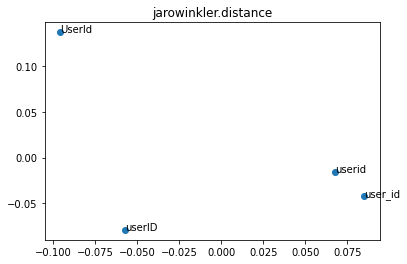

In [11]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, jarowinkler.distance)
plot_words(inconsistency_matrix, title = "jarowinkler.distance", annotate=True)

#### Longest Common Subsequence
The longest common subsequence (LCS) problem finds the longest subsequence common to two sequences. Subsequences are not required to occupy consecutive positions within the original sequences.

The LCS distance between strings $X$ (of length $n$) and $Y$ (of length $m$) is $n + m - 2 (LCS(X, Y)).$ It ranges from $[0, n + m]$

It has space and run time complexity  of $\mathcal{O}(M \times N)$.


In [12]:
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
lcs = LongestCommonSubsequence()
print('The lcs.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], lcs.distance(similar_strings[0], similar_strings[1])))

The lcs.distance between user_id and userid is 1


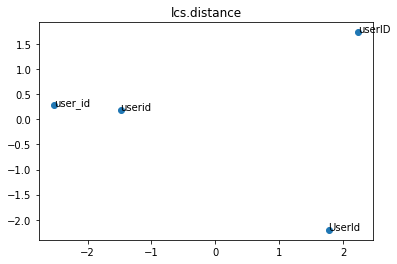

In [13]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, lcs.distance)
plot_words(inconsistency_matrix, title = "lcs.distance", annotate=True)

#### Metric Longest Common Subsequence
Based on Longest Common Subsequence, except now distance is
$ 1 - \frac{|LCS(X, Y)|}{max(|X|, |Y|)} $

In [14]:
from strsimpy.metric_lcs import MetricLCS

metric_lcs = MetricLCS()
print('The metric_lcs.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], metric_lcs.distance(similar_strings[0], similar_strings[1])))

The metric_lcs.distance between user_id and userid is 0.1428571428571429


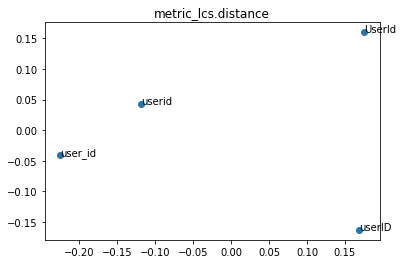

In [15]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, metric_lcs.distance)
plot_words(inconsistency_matrix, title = "metric_lcs.distance", annotate=True)

#### N-Gram 
The algorithm uses affixing with special character '\n' to increase the weight of first characters. The normalization is achieved by dividing the total similarity score the original length of the longest word. The main idea behind n-gram similarity is generalizing the concept of the longest
common subsequence to encompass n-grams, rather than just unigrams.

In [16]:
from strsimpy.ngram import NGram
fourgram = NGram(4)
print('The fourgram.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], fourgram.distance(similar_strings[0], similar_strings[1])))

The fourgram.distance between user_id and userid is 0.25


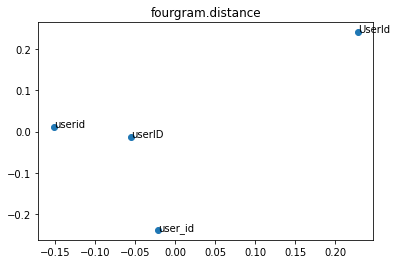

In [17]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, fourgram.distance)
plot_words(inconsistency_matrix, title = "fourgram.distance", annotate=True)

#### Dice Coefficient and other Q-Gram based algorithms 

These algorithms use Q-grams, size $Q$ sets of characters from each string to compute distance. Q-gram distance is a lower bound on Levenshtein distance, but can be computed in $\mathcal{O}(M + N)$ , where as Levenshtein requires $\mathcal{O}(M \times N)$. There are numerous variations like Jaccard index, Cosine similarity, Szymkiewicz-Simpson, etc. Since it is computationally more efficient, we recommend anyone using classic Levenstein to give a look into this one. 




In [18]:
from strsimpy.sorensen_dice import SorensenDice
dice = SorensenDice(2)
print('The 2-dice.distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], dice.distance(similar_strings[0], similar_strings[1])))

The 2-dice.distance between user_id and userid is 0.2727272727272727


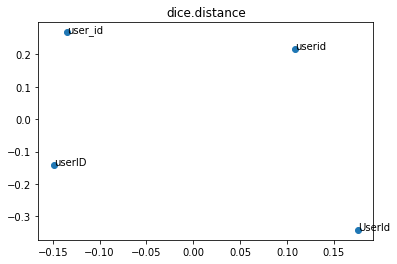

In [19]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, dice.distance)
plot_words(inconsistency_matrix, title = "dice.distance", annotate=True)

#### Needleman-Wunsch Global Alignment
Global sequence alignment allows us to compare two strings and find the sequence of "mutations" that lead from one to the other. The goal of sequence alignment is to find homologous/similar sequences in the strings, and then base mutations off of the gaps that emerge between these sequences.


In [20]:

seq1 = Seq(similar_strings[0]) 
seq2 = Seq(similar_strings[1])
def global_alignment_score(string1, string2):
    alignments = pairwise2.align.globalms(seq1, seq2, 5, -4, -4, -4) # all alignment will have the same score, return any
    return 5* max(len(similar_strings[0]), len(similar_strings[1])) - alignments[0].score

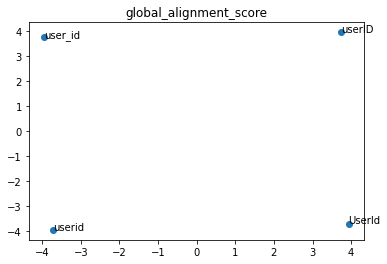

In [21]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, global_alignment_score)
plot_words(inconsistency_matrix, title = "global_alignment_score", annotate=True)

#### SIFT 4 
This is an algorithm claimed to have been developed to produce a distance measure that matches as close as possible to the human perception of string distance. It takes into account elements like character substitution, character distance, longest common subsequence etc. However, It was developed open-source using experimental testing, and without theoretical background.

In [22]:
from strsimpy import SIFT4

s = SIFT4()
print('The SIFT4 distance between {} and {} is {}'. \
    format(similar_strings[0], similar_strings[1], s.distance(similar_strings[0], similar_strings[1])))

The SIFT4 distance between user_id and userid is 1


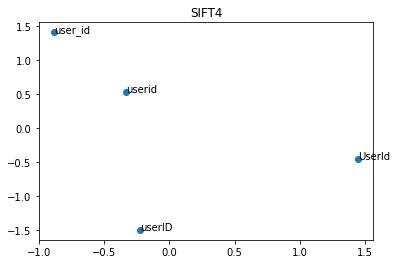

In [23]:
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, s.distance)
plot_words(inconsistency_matrix, title = "SIFT4", annotate=True)

#### $3-D$ plotting 
We can also do a couple $3-D$ visualizations to see how things would look. 

In [24]:
def plot_words_3d(inconsistency_matrix, title, annotate=False):
    embedding = MDS(n_components=3, dissimilarity  = "precomputed")
    fitted_strings = embedding.fit_transform(inconsistency_matrix)
    fitted_strings
    x = fitted_strings[:,0]
    y = fitted_strings[:,1]
    z = fitted_strings[:,2]
    return x, y, z

Text(0.5, 0.92, 'SIFT4 - 3D plot')

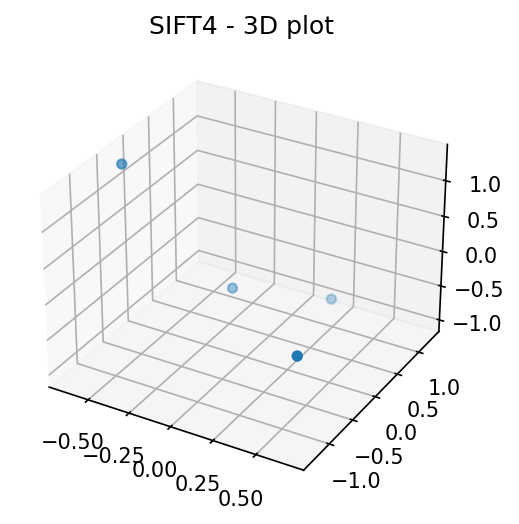

In [25]:
matplotlib.rcParams["figure.dpi"] = 150
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, s.distance)
x, y, z = plot_words_3d(inconsistency_matrix, "Sift4")
ax.scatter(x, y, z)
ax.set_title( "SIFT4 - 3D plot")

Text(0.5, 0.92, 'Dice - 3D plot')

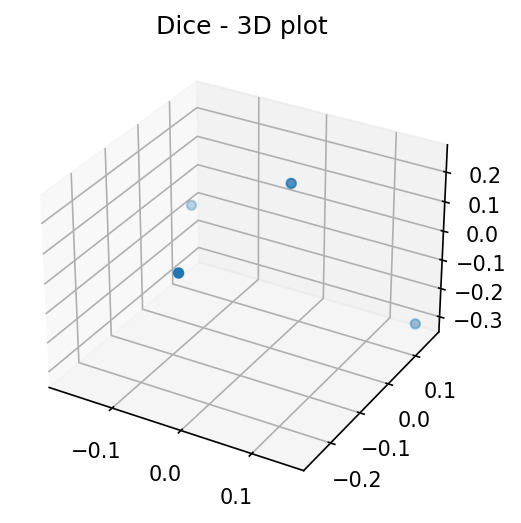

In [26]:
matplotlib.rcParams["figure.dpi"] = 150
fig = plt.figure()
ax = plt.axes(projection='3d')
inconsistency_matrix = calculate_dissimilarity_matrix(similar_strings, dice.distance)
x, y, z = plot_words_3d(inconsistency_matrix, "Dice")
ax.scatter(x, y, z)
ax.set_title( "Dice - 3D plot")

##### Using some of the algorithms to compute and plot the Google API vocabulary words

In [27]:
import pandas as pd
import os

simp_path = 'vocab.csv'
abs_path = os.path.abspath(simp_path)

In [28]:
df = pd.read_csv (abs_path)
words = []
for word in df.values:
    words.append(word[0]) 

In [29]:
res = []
for word in words:
    if isinstance(word, float):
        print(word)
    else:
        res.append(word)     

nan


In [30]:
inconsistency_matrix = calculate_dissimilarity_matrix(res[1:300], jarowinkler.distance)

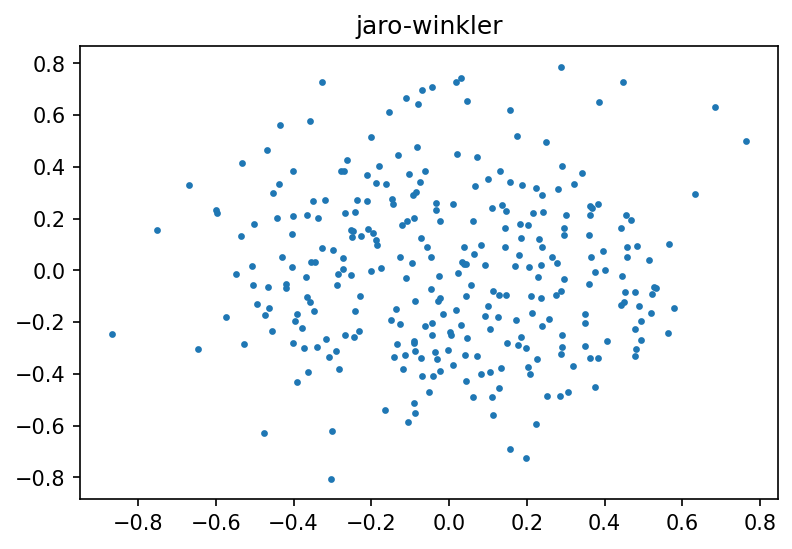

In [31]:
def plot_words2(inconsistency_matrix, title, annotate=False):
    embedding = MDS(n_components=2, dissimilarity  = "precomputed")
    fitted_strings = embedding.fit_transform(inconsistency_matrix)
    fitted_strings
    x = fitted_strings[:,0]
    y = fitted_strings[:,1]
    plt.scatter(x, y, s= 5)
    if annotate:
        for i, txt in enumerate(similar_strings):
            plt.annotate(txt, (x[i], y[i]))
    plt.title(title)
plot_words2(inconsistency_matrix, title = "jaro-winkler", annotate=False)

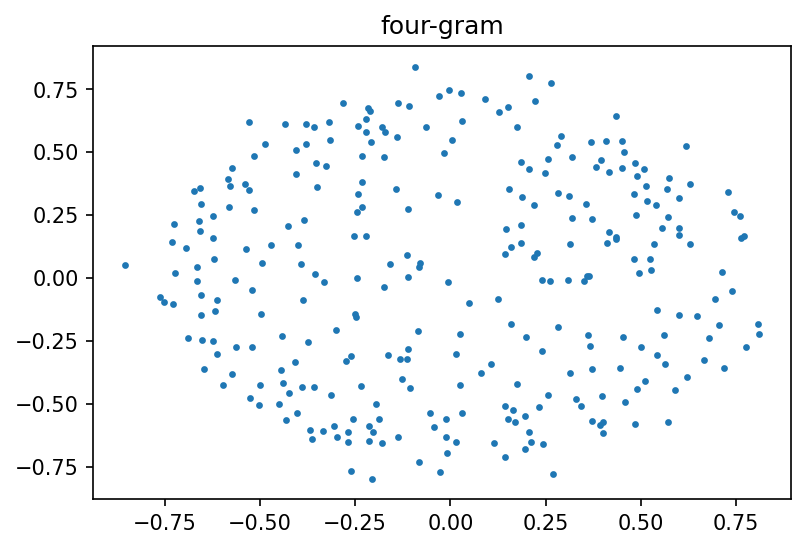

In [32]:
inconsistency_matrix = calculate_dissimilarity_matrix(res[1:300], fourgram.distance)
plot_words2(inconsistency_matrix, title = "four-gram", annotate=False)

#### plotting the entireity of Google's API words 

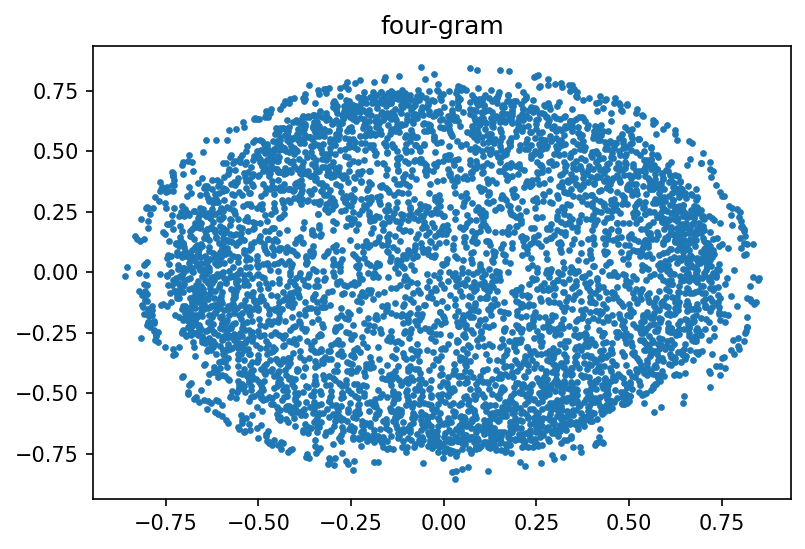

In [33]:
inconsistency_matrix = calculate_dissimilarity_matrix(res, fourgram.distance)
plot_words2(inconsistency_matrix, title = "four-gram", annotate=False)

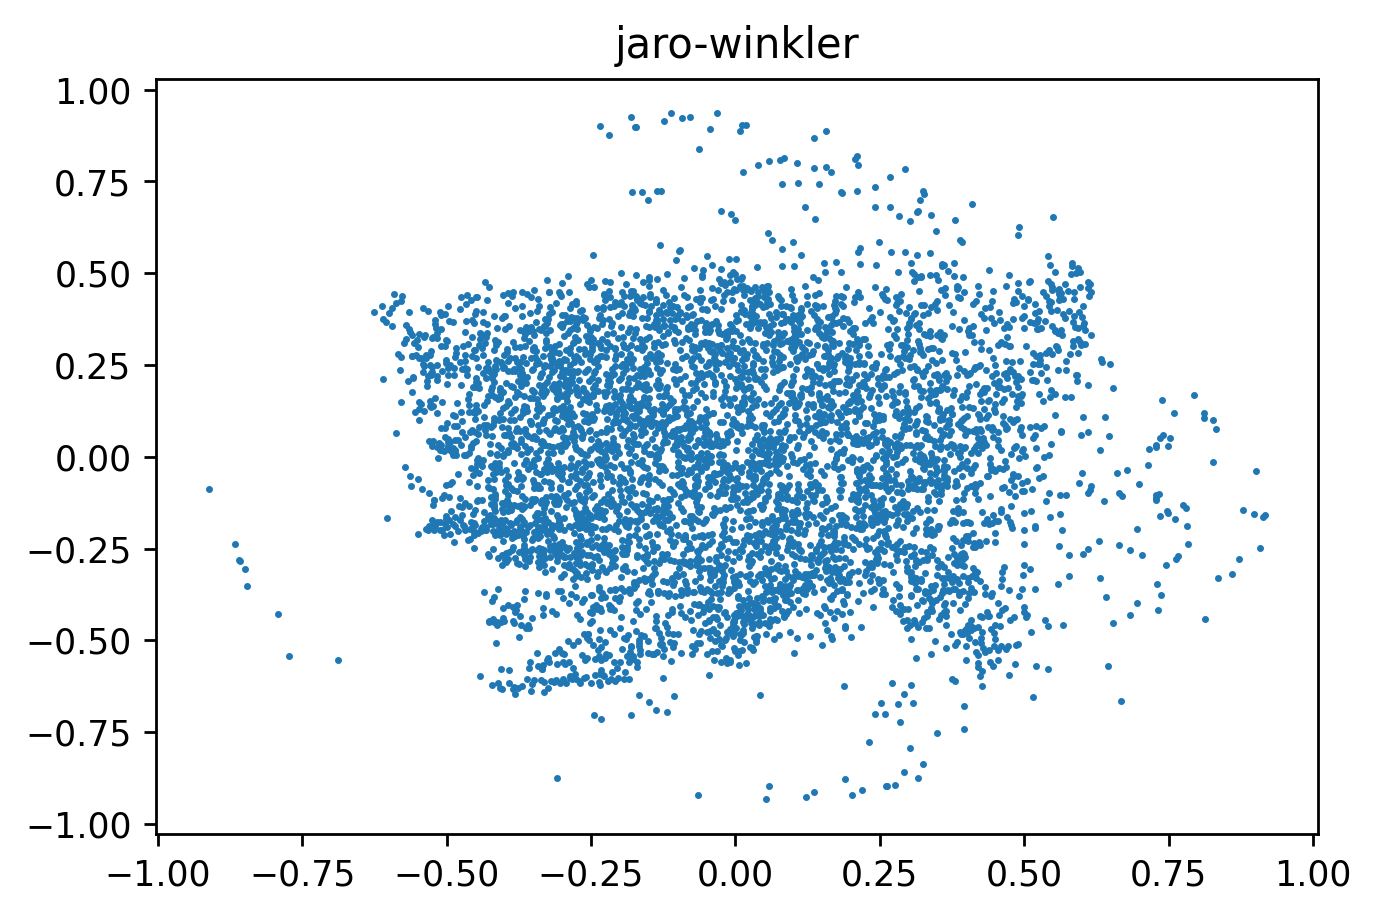

In [34]:
matplotlib.rcParams["figure.dpi"] = 250
def plot_words3(inconsistency_matrix, title, annotate=False):
    embedding = MDS(n_components=2, dissimilarity  = "precomputed")
    fitted_strings = embedding.fit_transform(inconsistency_matrix)
    fitted_strings
    x = fitted_strings[:,0]
    y = fitted_strings[:,1]
    plt.scatter(x, y, s= 1)
    if annotate:
        for i, txt in enumerate(similar_strings):
            plt.annotate(txt, (x[i], y[i]))
    plt.title(title)
inconsistency_matrix = calculate_dissimilarity_matrix(res, jarowinkler.distance)
plot_words3(inconsistency_matrix, title = "jaro-winkler", annotate=False)

In [35]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def extract_lv (array_1, array_2):
    return levenshtein.distance(array_1[0], array_2[0])

def extract_nlv (array_1, array_2):
    return normalized_levenshtein.distance(array_1[0], array_2[0])

def extract_jarowinkler (array_1, array_2):
    return jarowinkler.distance(array_1[0], array_2[0])

def extract_lcs (array_1, array_2):
    return lcs.distance(array_1[0], array_2[0])

def extract_dice (array_1, array_2):
    return dice.distance(array_1[0], array_2[0])

def extract_global_alignment (array_1, array_2):
    return global_alignment_score(array_1[0], array_2[0])

def extract_sift4 (array_1, array_2):
    return s.distance(array_1[0], array_2[0])

algorithm_wrapper = {
  levenshtein: extract_lv,
  normalized_levenshtein: extract_nlv,
  jarowinkler: extract_jarowinkler,
  lcs: extract_lcs,
  dice: extract_dice,
  global_alignment_score: extract_global_alignment,
  s: extract_sift4
}


In [36]:
### an even more efficient implementation to calculate the dissimilairty matrix using python's pairwise distance calculating function

def efficient_dissimilarity_matrix(strings, dissimilarity_measuring_algorithm, return_square_matrix = True):
    condensed_matrix = pdist(strings, algorithm_wrapper[dissimilarity_measuring_algorithm])
    if return_square_matrix:
        return squareform(condensed_matrix)
    return condensed_matrix


In [37]:
reshaped_words = np.reshape(similar_strings, (len(similar_strings), 1))
print(reshaped_words)
print(reshaped_words.shape)


[['user_id']
 ['userid']
 ['UserId']
 ['userID']]
(4, 1)


In [38]:
matrixx = efficient_dissimilarity_matrix(reshaped_words, normalized_levenshtein)
print(matrixx)

[[0.         0.14285714 0.42857143 0.42857143]
 [0.14285714 0.         0.33333333 0.33333333]
 [0.42857143 0.33333333 0.         0.33333333]
 [0.42857143 0.33333333 0.33333333 0.        ]]


In [39]:
simp_path = 'vocab1000.csv'
abs_path = os.path.abspath(simp_path)
tagged_df = pd.read_csv (abs_path)
tagged_df = tagged_df.drop(tagged_df.index[1000:])
word_labels = tagged_df.iloc[:, 0]
word_labels = word_labels.to_numpy()
tagged_words = tagged_df.iloc[:, 1]
tagged_words = tagged_words.to_numpy()

In [40]:
tagged_words_dissimilairty = efficient_dissimilarity_matrix(tagged_words.reshape(len(tagged_words), 1), normalized_levenshtein, return_square_matrix = True)

In [41]:
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from sklearn.cluster import dbscan
     
data = tagged_words
print(data[0])

normalized_levenshtein = NormalizedLevenshtein()
print(normalized_levenshtein.distance('My string', 'My string'))

Abandon
0.0


In [42]:
import numpy as np
from sklearn.cluster import dbscan
data = tagged_words
def extract_indices_lv(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return levenshtein.distance(data[i], data[j])
def extract_indices_nlv(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return normalized_levenshtein.distance(data[i], data[j])
def extract_indices_jarowinkler(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return jarowinkler.distance(data[i], data[j])
def extract_indices_lcs(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return lcs.distance(data[i], data[j])
def extract_indices_dice(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return dice.distance(data[i], data[j])
def extract_indices_sift4(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return s.distance(data[i], data[j])    

X = np.arange(len(data)).reshape(-1, 1)
# We need to specify algoritum='brute' as the default assumes
# a continuous feature space.


##### using dbscan to callculate labes for our wirds using normalized levenstien. 

In [43]:
db = dbscan(X, metric=extract_indices_nlv, eps=.3, min_samples=2, algorithm='brute')
print("the number of unique lables generated by dbscan is: ", len(set(db[1])))


the number of unique lables generated by dbscan is:  184


In [44]:
db = dbscan(X, metric=extract_indices_dice, eps=.3, min_samples=2, algorithm='brute')
print("the number of unique lables generated by dbscan is: ", len(set(db[1])))

the number of unique lables generated by dbscan is:  227


In [45]:
word_labels = np.array([int(i) for i in word_labels])
print(word_labels.shape)

(1000,)


### we can find predicted lables for each algorithm using dbscan 

In [46]:
def compute_predicted_lables(data, algorithm, dbscan_eps, dbscan_min_samples):
    db = dbscan(data, metric=algorithm, eps=dbscan_eps, min_samples=dbscan_min_samples, algorithm='brute')
    return db[1]

In [47]:
lables = compute_predicted_lables(data = X, algorithm = extract_indices_nlv, dbscan_eps = .3, dbscan_min_samples = 2)

#### we can qunaitfy how well our lableing worked by using the following clutering metrics. 
##### Homogeniety: A clustering result satisfies homogeneity if all of its clusters contain only points which are members of a single class
##### Completeness: A clustering result satisfies completeness if all points that are members of a given class are elements of the same cluster.
##### V-measure: the harmonic mean between homogeneity and completeness. We use this for our performance analysis. 

In [48]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
v = v_measure_score(word_labels, lables)
c = completeness_score(word_labels, lables)
h = homogeneity_score(word_labels, lables)
print(" the v measure score for normalized levenstein is: ", str(round(v,2)*100) + "%")
print(" the completeness score for normalized levenstein is: ", str(round(c,2)*100) + "%")
print(" the homogeniety score for normalized levenstein is: ", str(round(h,2)*100) + "%")

 the v measure score for normalized levenstein is:  84.0%
 the completeness score for normalized levenstein is:  96.0%
 the homogeniety score for normalized levenstein is:  75.0%


In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
params = [{'dbscan_eps': [.1, .2, .3, .4, .5, .6, .7, .8, .9],
         'dbscan_min_samples': [2, 3, 4, 5, 6, 7, 8, 9],
         }]


In [50]:
dbscan_eps_values =  [.1, .2, .3, .4, .5, .6, .7, .8, .9]
dbscan_min_samples = [2, 3, 4, 5, 6, 7, 8, 9]
best_eps = -1
best_min_value = -1
best_score = 0 
for i in dbscan_eps_values:
    for j in dbscan_min_samples:
        lables = compute_predicted_lables(data = X, algorithm = extract_indices_nlv, dbscan_eps = i, dbscan_min_samples = j)
        current_score = v_measure_score(word_labels, lables)
        if (current_score > best_score):
            best_score = current_score
            best_eps = i
            best_min_value = j
print(best_eps, best_min_value, best_score)

0.2 2 0.845141324060927


In [51]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score 
lables = compute_predicted_lables(data = X, algorithm = extract_indices_nlv, dbscan_eps = .2, dbscan_min_samples = 2)
current_score = homogeneity_score(word_labels, lables)
print(current_score)

0.774478146143454


#### we can do grid searches like this as sown in the other notebook. 